In [ ]:
# BMED318 Week10. Hands-on. Image Restoration 
import numpy as np
import matplotlib.pyplot as plt
import skimage.util as ut
from numpy.fft import ifft2, fft2, fftshift, ifftshift
import skimage.exposure as ex

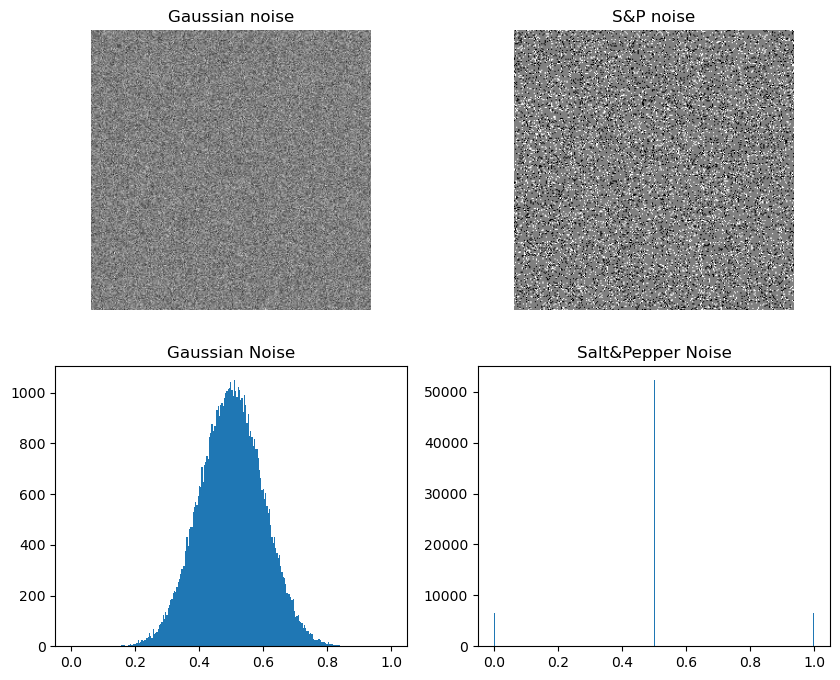

'\n가우시안 노이즈는 히스토그램이 0.5를 중심으로 부드러운 종 모양을 이룹니다.\n이는 이미지의 모든 픽셀이 0.5 근처에서 무작위로 조금씩 변경되었고 그 변화량이 정규분포를 따름을 의미합니다.\n\nSalt & Pepper 노이즈는 히스토그램이 0 (pepper), 0.5 (원본), 1 (salt) 세 군데에서만 뾰족하게 보입니다.\n이는 일부 픽셀만 선택되어 완전한 검은색(0) 또는 흰색(1)으로 대체되었고 나머지 대부분의 픽셀은 아예 변하지 않았음을 보여줍니다.\n'

In [ ]:
# 1.a) Make a 256x256 image with pixel values set to 0.5.  
img = np.ones((256, 256), dtype=np.float32) * 0.5

# 1.b) Add Gaussian noise and salt-and-pepper noise.  
img_sp = ut.random_noise(img, mode='s&p', amount=0.2)
img_g = ut.random_noise(img, mode='gaussian')

# 1.c) Make histograms of two noise images that you created in b).  
plt.figure(figsize=(10,8))
plt.subplot(221); plt.imshow(img_g, cmap='gray', vmin=0, vmax=1); plt.title('Gaussian noise'); plt.axis('off')
plt.subplot(222); plt.imshow(img_sp, cmap='gray', vmin=0, vmax=1); plt.title('S&P noise'); plt.axis('off')
plt.subplot(223); plt.hist(img_g.ravel(), bins=256, range=[0,1]); plt.title('Gaussian Noise')
plt.subplot(224); plt.hist(img_sp.ravel(), bins=256, range=[0,1]); plt.title('Salt&Pepper Noise')

plt.show()

# 1.d) Display the created two noise images and their histograms within a figure window.
# Discuss the characteristics of Gaussian noise and salt-and-pepper noise based on the histograms. 
'''
가우시안 노이즈는 히스토그램이 0.5를 중심으로 부드러운 종 모양을 이룹니다.
이는 이미지의 모든 픽셀이 0.5 근처에서 무작위로 조금씩 변경되었고 그 변화량이 정규분포를 따름을 의미합니다.

Salt & Pepper 노이즈는 히스토그램이 0 (pepper), 0.5 (원본), 1 (salt) 세 군데에서만 뾰족하게 보입니다.
이는 일부 픽셀만 선택되어 완전한 검은색(0) 또는 흰색(1)으로 대체되었고 나머지 대부분의 픽셀은 아예 변하지 않았음을 보여줍니다.
'''

In [ ]:
# 2.a) Read lena_noise.png 
lena_noise = plt.imread('lena_noise.png')

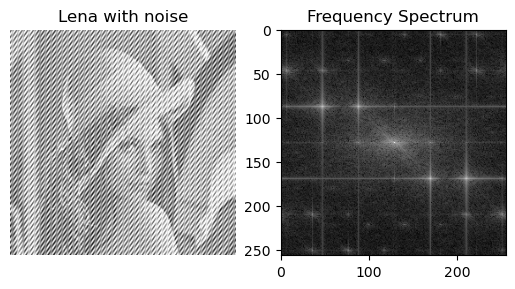

'\n정중앙 좌표인 (128,128)을 기준으로 대칭적인 십자모양의 노이즈 성분을 확인할 수 있습니다.\n그 중 크기가 큰 노이즈 성분(x,y)으로는 (46,87),(87,87),(169,169),(209,169)가 있고\n이외에 row [5, 35, 47, 208, 220, 250]의 선과\ncolumn [6, 35, 221, 250]의 선에 노이즈 선이 존재합니다.\n'

In [ ]:
# 2.b) Find the periodic noises locations of the frequency spectrum of the image
# (Place the mouse on the spectrum image to find the pixel index). 
G_lena = fftshift(fft2(lena_noise))
G_lena_mag = np.log1p(np.abs(G_lena))
plt.figure(); 
plt.subplot(1, 2, 1); plt.imshow(lena_noise, cmap='gray')
plt.title('Lena with noise'); plt.axis('off')
plt.subplot(1, 2, 2); plt.imshow(G_lena_mag, cmap='gray')
plt.title('Frequency Spectrum')
plt.show()

'''
정중앙 좌표인 (128,128)을 기준으로 대칭적인 십자모양의 노이즈 성분을 확인할 수 있습니다.
그 중 크기가 큰 노이즈 성분(x,y)으로는 (46,87),(87,87),(169,169),(209,169)가 있고
이외에 row [5, 35, 47, 208, 220, 250]의 선과
column [6, 35, 221, 250]의 선에 노이즈 선이 존재합니다.
'''

In [ ]:
# 2.c)
#  Apply the appropriate filter (e.g, 2D band-reject filter or notch filter, etc) using ideal high pass filter.
# Try multiple radiuses and bandwidths of the filter to achieve the best restoration result.
M,N = G_lena.shape
cy,cx = 128,128

temp = ex.rescale_intensity(G_lena_mag, out_range=(0,1))
gf2 = ut.img_as_ubyte(temp)
gf2[cy,cx] = 0 # location of DC, 피크 찾기에서 제외

# =============================================================================
# notch mask
# =============================================================================
threshold = 0.83*gf2.max()
i,j = np.where(gf2>threshold)

notch_mask = np.ones_like(G_lena, dtype=float)
notch_mask[i, :] = 0
notch_mask[:, j] = 0

manual_rows = [5, 35, 47, 208, 220, 250]
manual_cols = [6, 35, 221, 250]
notch_mask[manual_rows, :] = 0
notch_mask[:, manual_cols] = 0


# =============================================================================
# band reject filer
# =============================================================================

k=3 # Bandwidth
y,x = np.indices((M,N))
z = np.sqrt((x-cx)**2 + (y-cy)**2)

i, j = 46, 87
d1 = np.sqrt((i - cy)**2 + (j - cx)**2)
br_mask1 = (z < np.floor(d1 - k)) | (z > np.ceil(d1 + k))
br_mask1 = br_mask1.astype(float)

i, j = 87, 87
d2 = np.sqrt((i - cy)**2 + (j - cx)**2)
br_mask2 = (z < np.floor(d2 - k)) | (z > np.ceil(d2 + k))
br_mask2 = br_mask2.astype(float)

i, j = 169, 169
d3 = np.sqrt((i - cy)**2 + (j - cx)**2)
br_mask3 = (z < np.floor(d3 - k)) | (z > np.ceil(d3 + k))
br_mask3 = br_mask3.astype(float)

i, j = 209, 169
d4 = np.sqrt((i - cy)**2 + (j - cx)**2)
br_mask4 = (z < np.floor(d4 - k)) | (z > np.ceil(d4 + k))
br_mask4 = br_mask4.astype(float)


br_mask = br_mask1 * br_mask2 * br_mask3 * br_mask4

# =============================================================================
# final mask 
# =============================================================================
final_mask = notch_mask*br_mask

gfr = G_lena*final_mask # filtered spectrum
lena_restored = np.abs(ifft2(ifftshift(gfr)))

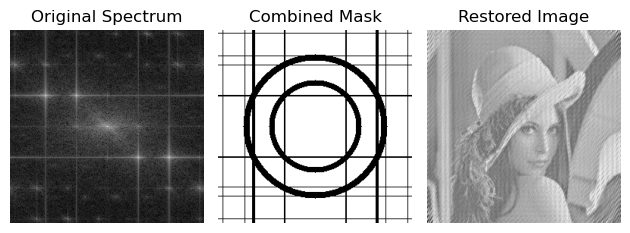

In [ ]:
# 2.d) Display the frequency spectrum and the final resultant image. 
plt.figure()

plt.subplot(1, 3, 1)
plt.imshow(G_lena_mag, cmap='gray')
plt.title('Original Spectrum')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(final_mask, cmap='gray')
plt.title('Combined Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(lena_restored, cmap='gray')
plt.title('Restored Image')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# 3.a) Read ‘keyboard.png’. This image is degraded by gaussian filter (size: (15, 15), sigma: 0.9) 
keyboard = plt.imread('keyboard.png')
M,N = keyboard.shape

# 3.b) Restore the image using the simple inverse filter. 
sigma = 0.9
kernel_size = 15

ky, kx = np.mgrid[-(kernel_size//2):(kernel_size//2)+1, -(kernel_size//2):(kernel_size//2)+1]
kernel_h = np.exp(-(kx**2 + ky**2) / (2 * sigma**2))
kernel_h = kernel_h / kernel_h.sum() # 정규화

h_padded = np.zeros((M, N))
r_start = M // 2 - kernel_size // 2
r_end = r_start + kernel_size
c_start = N // 2 - kernel_size // 2
c_end = c_start + kernel_size
h_padded[r_start:r_end, c_start:c_end] = kernel_h

H = fftshift(fft2(ifftshift(h_padded)))
G = fftshift(fft2(keyboard))

epsilon = 1e-8 
F_hat_inverse = G / (H + epsilon)
f_hat_inverse = np.abs(ifft2(ifftshift(F_hat_inverse)))

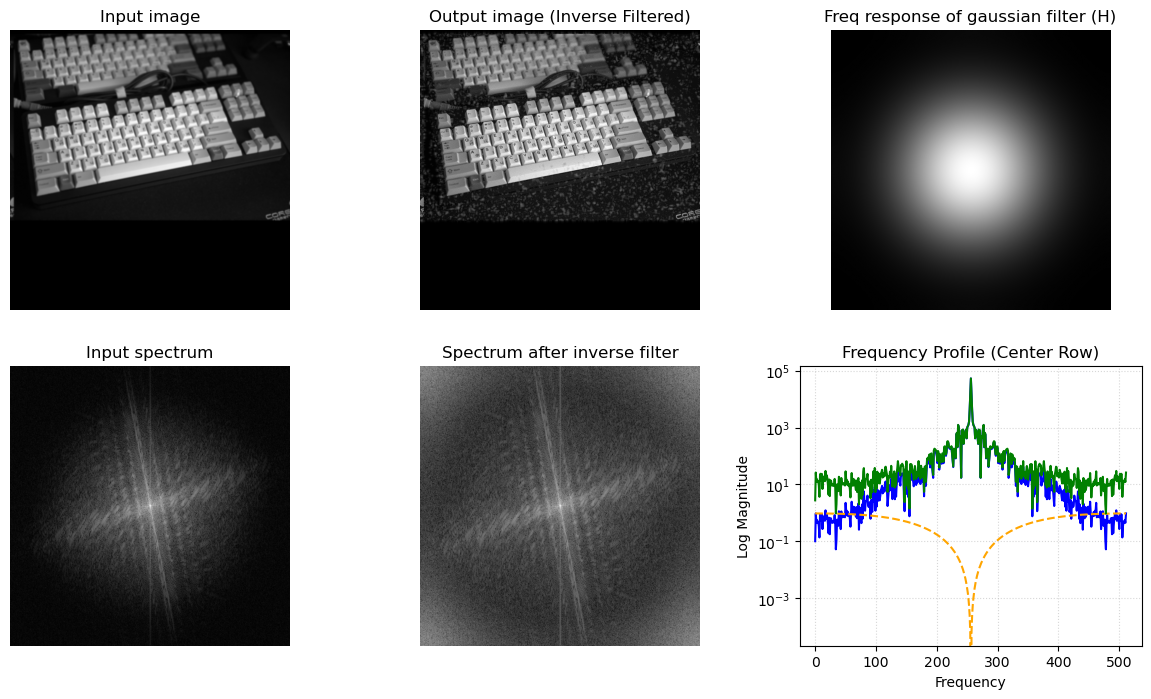

In [ ]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1); plt.imshow(keyboard, cmap='gray'); plt.title("Input image"); plt.axis('off')
plt.subplot(2, 3, 2); plt.imshow(f_hat_inverse, cmap='gray', vmin=0, vmax=1); plt.title("Output image (Inverse Filtered)"); plt.axis('off')
plt.subplot(2, 3, 3); plt.imshow(np.abs(H), cmap='gray'); plt.title("Freq response of gaussian filter (H)"); plt.axis('off')
plt.subplot(2, 3, 4); plt.imshow(np.log1p(np.abs(G)), cmap='gray'); plt.title("Input spectrum"); plt.axis('off')
plt.subplot(2, 3, 5); plt.imshow(np.log1p(np.abs(F_hat_inverse)), cmap='gray'); plt.title("Spectrum after inverse filter"); plt.axis('off')
plt.subplot(2, 3, 6)
mid_row = M // 2
spec_G = np.abs(G[mid_row, :])
spec_H = 1 - np.abs(H[mid_row, :])
spec_F_inverse = np.abs(F_hat_inverse[mid_row, :])

plt.plot(spec_G, label='Degraded Spectrum (G)', color='blue')
plt.plot(spec_H, label='Gaussian Filter (H)', color='orange', linestyle='--')
plt.plot(spec_F_inverse, label='Inverse Restored Spectrum', color='green')

plt.yscale('log')
plt.title("Frequency Profile (Center Row)"); plt.xlabel("Frequency"); plt.ylabel("Log Magnitude");
#plt.legend()
#plt.ylim(10**-3, 10**7); 
plt.grid(True, linestyle=':', alpha=0.5)

plt.show()

In [ ]:
# 3.c) Restore the image using Wiener filter. Make the best restored image by adjusting the value of K.
# (Try multiple values of K from 0.01 to 1.0) 
K = 0.02 # 0.01~1.0사이로 조절

H_conj = np.conj(H)
H_abs_sq = np.abs(H)**2
wiener_filter_freq = H_conj / (H_abs_sq + K)

F_hat_wiener = wiener_filter_freq * G
f_hat_wiener = np.abs(ifft2(ifftshift(F_hat_wiener)))

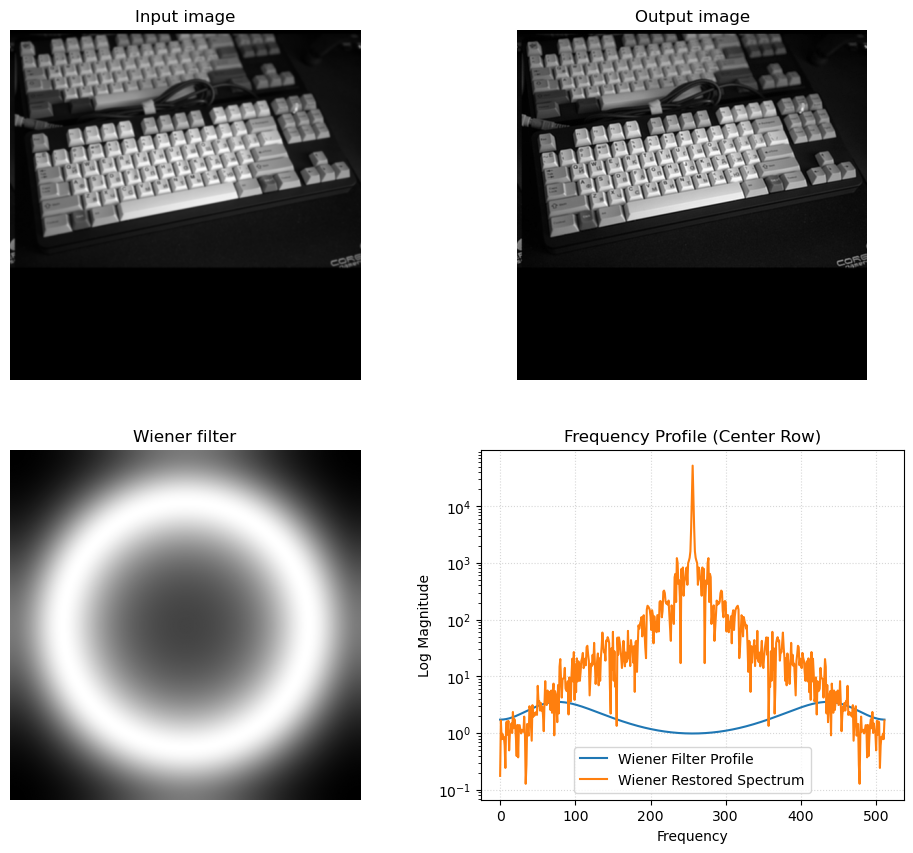

In [ ]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1); plt.imshow(keyboard, cmap='gray'); plt.title("Input image"); plt.axis('off')

plt.subplot(2, 2, 2); plt.imshow(f_hat_wiener, cmap='gray', vmin=0, vmax=1); plt.title("Output image"); plt.axis('off')

plt.subplot(2, 2, 3); plt.imshow(np.abs(wiener_filter_freq), cmap='gray'); plt.title("Wiener filter"); plt.axis('off')

plt.subplot(2, 2, 4)
mid_row = M // 2
# spec_wiener_filter = np.log1p(np.abs(wiener_filter_freq[mid_row, :]))
# spec_F_wiener = np.log1p(np.abs(F_hat_wiener[mid_row, :]))
spec_wiener_filter = np.abs(wiener_filter_freq[mid_row, :])
spec_F_wiener = np.abs(F_hat_wiener[mid_row, :])

plt.plot(spec_wiener_filter, label='Wiener Filter Profile')
plt.plot(spec_F_wiener, label='Wiener Restored Spectrum')
plt.yscale('log')
plt.title("Frequency Profile (Center Row)")
plt.xlabel("Frequency")
plt.ylabel("Log Magnitude")
plt.legend()
#plt.ylim(10**0, 10**7)
plt.grid(True, linestyle=':', alpha=0.5)


plt.show()

In [ ]:
# 3.d) Discuss the restored images b) and c).  
'''
b)의 Simple Inverse Filter를 적용한 이미지는 노이즈가 심합니다.
이것은 필터가 흐릿한 이미지를 선명하게 만들려고 할 때 이미지에 원래 있던 작은 노이즈까지 엄청나게 크게 증폭시켰기 때문입니다.
Frequency Profile의 초록색 선이 고주파에서 폭발적으로 튀는 것이 이 현상을 증명합니다.

c)의 Wiener Filter를 쓴 이미지는 (b)와 달리 노이즈가 거의 사라지고 키보드 글자도 선명하게 잘 복원되었습니다.
이 필터는 K=0.02을 사용해서 노이즈가 심하게 증폭될 것 같은 부분은 적절히 억제해주는 기능이 있기 때문입니다. 
'''

'\nb)의 Simple Inverse Filter를 적용한 이미지는 노이즈가 심합니다.\n이것은 필터가 흐릿한 이미지를 선명하게 만들려고 할 때 이미지에 원래 있던 작은 노이즈까지 엄청나게 크게 증폭시켰기 때문입니다.\nFrequency Profile의 초록색 선이 고주파에서 폭발적으로 튀는 것이 이 현상을 증명합니다.\n\nc)의 Wiener Filter를 쓴 이미지는 (b)와 달리 노이즈가 거의 사라지고 키보드 글자도 선명하게 잘 복원되었습니다.\n이 필터는 K=0.02을 사용해서 노이즈가 심하게 증폭될 것 같은 부분은 적절히 억제해주는 기능이 있기 때문입니다. \n'

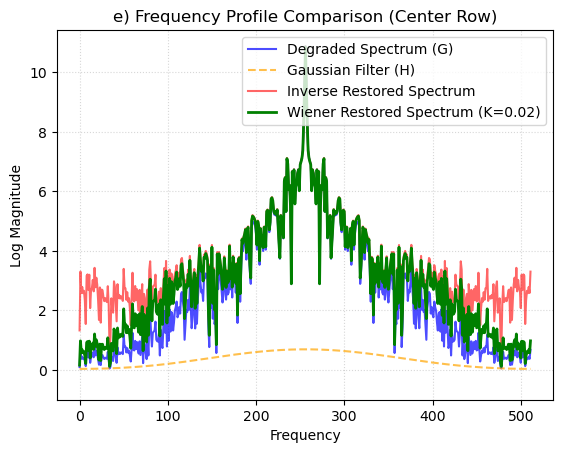

In [ ]:
# 3.e) Display the images and plots that you think you need to show to explain your work.
# e.g. profile comparison among the different filter responses in frequency domain
'''
(e)번 주파수 프로파일 그래프는 각 필터가 주파수 영역에서 어떻게 작동하는지 보여줍니다.
이 그래프는 2D 스펙트럼의 중앙 가로줄을 1D로 펼친 것으로 중앙은 저주파를 양쪽 끝은 고주파를 의미합니다.
Simple Inverse Filter (붉은색 선)는 가우시안 필터(주황색) 값이 0에 가까워지는 고주파 영역에서 노이즈를 과도하게 증폭시켜,
그래프가 폭발적으로 튀는 것을 볼 수 있습니다. 이것이 (b)번 이미지에 노이즈가 가득한 원인입니다.

반면 Wiener Filter (초록색 선)는 K값(0.03) 덕분에 노이즈가 증폭되는 고주파 영역을 효과적으로 억제하는 동시에
복원이 필요한 저주파수 성분은 되살리는 것을 보여줍니다. 그 결과 (c)번처럼 노이즈는 억제되고 이미지는 선명하게 복원되었습니다.
'''

plt.figure()
mid_row = M // 2

spec_G = np.log1p(np.abs(G[mid_row, :]))
spec_H = np.log1p(np.abs(H[mid_row, :]))
spec_F_inverse = np.log1p(np.abs(F_hat_inverse[mid_row, :]))
spec_F_wiener = np.log1p(np.abs(F_hat_wiener[mid_row, :]))

plt.plot(spec_G, label='Degraded Spectrum (G)', alpha=0.7, color='blue')
plt.plot(spec_H, label='Gaussian Filter (H)', alpha=0.7, color='orange', linestyle='--')
plt.plot(spec_F_inverse, label='Inverse Restored Spectrum', alpha=0.6, color='red')
plt.plot(spec_F_wiener, label=f'Wiener Restored Spectrum (K={K})', linewidth=2, color='green')

plt.title("e) Frequency Profile Comparison (Center Row)")
plt.xlabel("Frequency")
plt.ylabel("Log Magnitude")
plt.legend(); plt.ylim(bottom=-1)
plt.grid(True, linestyle=':', alpha=0.5)

plt.show()